# Importing dataset


Mounting google drive to get access to dataset

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/SML/fake_or_real_news.csv'

df = pd.read_csv(file_path)

print(df.head())

Mounted at /content/drive
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import re
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from textblob import TextBlob
import joblib
from google.colab import files

# Downloading stopwords
nltk.download('stopwords')
import nltk

# Downloading WordNet
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Preprocessing


Preprocessing- Getting rid of rows with missing values.

In [3]:
df.dropna(inplace=True)
print(f"DataFrame shape after dropping missing values: {df.shape}")

DataFrame shape after dropping missing values: (6335, 4)


Preprocessing- Checking the data types in 'text' and 'title' columns

In [4]:
print(df['text'].apply(type).value_counts())
print(df['title'].apply(type).value_counts())

text
<class 'str'>    6335
Name: count, dtype: int64
title
<class 'str'>    6335
Name: count, dtype: int64


Preprocessing-
1.Combining title and text
2. Text cleaning using Lemmatization
3.Getting rid of special characters, characters outside ASCII range,numbers. Converting to lower case and splitting into words
4. Feature Engineering

In [5]:
# 1.
df['combined_text'] = df['title'] + " " + df['text']

# 2.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#3.
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) #Remove special characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)#Remove characters outide ASCII range
    text = re.sub(r'\d+', '', text)# Remove numbers
    text = text.lower()  # Convert to lowercase
    words = text.split()  # Split into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize & remove stopwords
    return " ".join(words)

df['cleaned_text'] = df['combined_text'].apply(preprocess_text)

# 3.
df['text_length'] = df['cleaned_text'].apply(len)
df['num_unique_words'] = df['cleaned_text'].apply(lambda x: len(set(x.split())))



Preprocessing- Sentiment analysis

In [6]:
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

Preprocessing- Splitting data into training and testing sets

In [7]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preprocessing- Vectorization of data using TF-IDF vectorizer

In [8]:
tfidf = TfidfVectorizer(stop_words='english',max_features=100)

In [9]:
tfidf_train=tfidf.fit_transform(X_train)
tfidf_test=tfidf.transform(X_test)

Preprocessing- Saving preprocessed data into a csv file

In [10]:
df.to_csv('fake_vs_real_news2.csv', index=False)

# EDA-Exploratory Data Analysis

EDA- Checking the number of fake and real data

In [ ]:
i=df.label.value_counts()
print(i)

label
REAL    3171
FAKE    3164
Name: count, dtype: int64


EDA- Number of empty values in each feature

In [ ]:
print(df.isnull().sum())

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


EDA- Plotting number of fake and real entries in the dataset using matplotlib

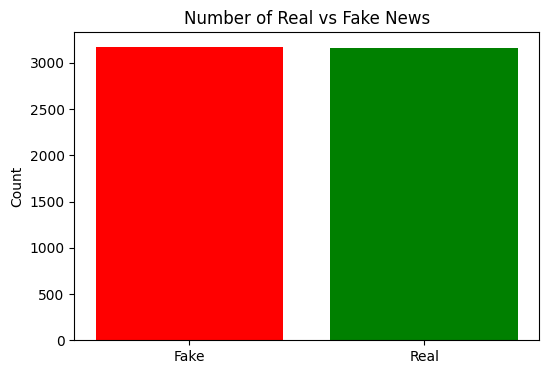

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(['Fake', 'Real'], i, color=['red', 'green'])
plt.title('Number of Real vs Fake News')
plt.ylabel('Count')
plt.show()

EDA- Plotting TF-IDF scores of top 10 terms occuring across the documents

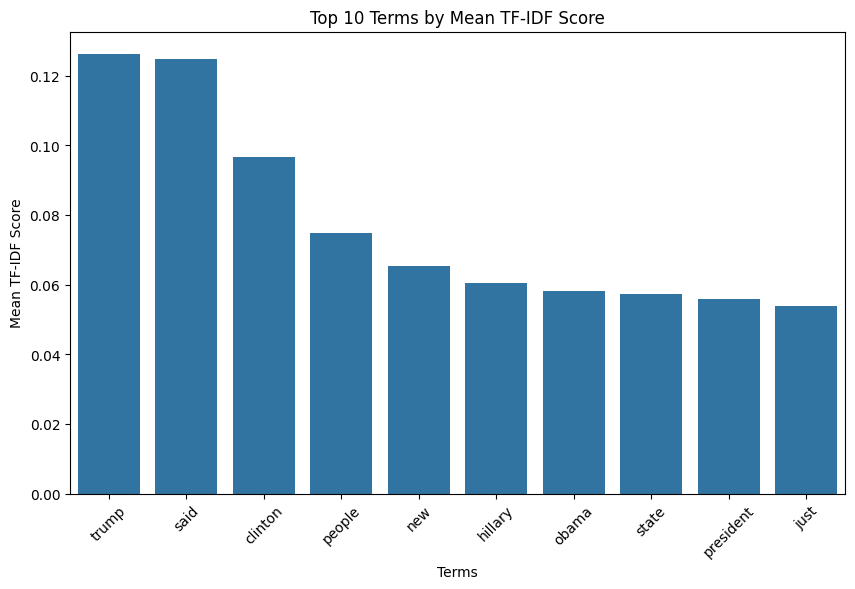

In [ ]:
tfidf_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf.get_feature_names_out())

# Calculate the mean TF-IDF score for each term across the training documents
mean_tfidf = tfidf_df.mean(axis=0).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_tfidf.index[:10], y=mean_tfidf.values[:10])  # Plot top 10 terms
plt.xticks(rotation=45)
plt.title("Top 10 Terms by Mean TF-IDF Score")
plt.xlabel("Terms")
plt.ylabel("Mean TF-IDF Score")
plt.show()

#Model Application

Models used-
1. Bernoulli Naive Bayes
2. Decision tree classifier
3. Random forest
4. Logistic Regression

In [11]:
model = BernoulliNB()
model.fit(tfidf_train, y_train)

# 4. Make Predictions
y_pred = model.predict(tfidf_test)

# 5. Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7182320441988951

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.70      0.75      0.72       628
        REAL       0.73      0.69      0.71       639

    accuracy                           0.72      1267
   macro avg       0.72      0.72      0.72      1267
weighted avg       0.72      0.72      0.72      1267


Confusion Matrix:
 [[468 160]
 [197 442]]


In [12]:
model2 = LogisticRegression(max_iter=1000)
model2.fit(tfidf_train, y_train)

# 4. Make Predictions
y_pred = model2.predict(tfidf_test)

# 5. Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8397790055248618

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.85      0.82      0.84       628
        REAL       0.83      0.86      0.84       639

    accuracy                           0.84      1267
   macro avg       0.84      0.84      0.84      1267
weighted avg       0.84      0.84      0.84      1267


Confusion Matrix:
 [[516 112]
 [ 91 548]]


In [13]:
model3 = DecisionTreeClassifier(random_state=42)
model3.fit(tfidf_train, y_train)

# 4. Make Predictions
y_pred = model3.predict(tfidf_test)

# 5. Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7774269928966061

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.78      0.77      0.77       628
        REAL       0.78      0.78      0.78       639

    accuracy                           0.78      1267
   macro avg       0.78      0.78      0.78      1267
weighted avg       0.78      0.78      0.78      1267


Confusion Matrix:
 [[485 143]
 [139 500]]


In [14]:
model4 = RandomForestClassifier(n_estimators=100, random_state=42)
model4.fit(tfidf_train, y_train)

# 4. Make Predictions
y_pred = model4.predict(tfidf_test)

# 5. Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8674033149171271

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.87      0.87      0.87       628
        REAL       0.87      0.87      0.87       639

    accuracy                           0.87      1267
   macro avg       0.87      0.87      0.87      1267
weighted avg       0.87      0.87      0.87      1267


Confusion Matrix:
 [[545  83]
 [ 85 554]]


In [15]:
# Define each individual model
bernoulli_nb = BernoulliNB()
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
log_reg = LogisticRegression(max_iter=1000)

# Combine them into a voting classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('bernoulli_nb', bernoulli_nb),
        ('random_forest', random_forest),
        ('decision_tree', decision_tree),
        ('log_reg', log_reg)
    ],
    voting='soft'  # Use 'soft' voting for averaging probabilities
)

# Train the ensemble model
ensemble_model.fit(tfidf_train, y_train)


VotingClassifier(estimators=[('bernoulli_nb', BernoulliNB()),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('decision_tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('log_reg', LogisticRegression(max_iter=1000))],
                 voting='soft')

Checking accuracy of the model using-
1. Accuracy score
2. Classification report
3. Confusion matrix

In [16]:
y_pred = ensemble_model.predict(tfidf_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Accuracy:", accuracy)

# Display detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Show confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Ensemble Model Accuracy: 0.8524072612470402
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.85      0.86      0.85       628
        REAL       0.86      0.85      0.85       639

    accuracy                           0.85      1267
   macro avg       0.85      0.85      0.85      1267
weighted avg       0.85      0.85      0.85      1267

Confusion Matrix:
 [[540  88]
 [ 99 540]]


To check order of classes

In [ ]:
print(ensemble_model.classes_)

# Exporting ensemble model and vectorizer

Saving and downloading the ensemble model and vectorizer as pickle files

In [ ]:
joblib.dump(ensemble_model, 'ensemble_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
files.download('ensemble_model.pkl')
files.download('tfidf_vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>